In [ ]:
import sys
print(sys.version)


3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]


# Revenue Leakage in Subscription Businesses  
## A McKinsey Digital–Style Analytics Case

### Client Context
A subscription-based telecom provider is experiencing stagnant revenue despite stable customer acquisition.
Leadership suspects revenue leakage driven by preventable churn and misallocated retention spending.

### Engagement Objective
Identify which customer segments drive the majority of revenue leakage and design data-driven interventions
that maximize retention ROI.

### Initial Hypotheses
1. Revenue leakage is concentrated in mid-tenure, mid-ARPU customers  
2. High-discount customers are not the most profitable to retain  
3. Service-related friction predicts churn more strongly than pricing  
4. Blanket retention offers destroy value versus targeted interventions


## 1. Environment Setup & Imports
We begin by setting up the Python environment and importing core analytics libraries.


In [ ]:
import sys
print(sys.version)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


## 2. Data Ingestion & Initial Exploration

We use a real-world telecom subscription dataset to simulate a consulting-style engagement.
The dataset contains customer demographics, services, billing details, and churn outcomes.


In [ ]:
# Load dataset directly from source
url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"
df = pd.read_csv(url)

df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
df.shape


(7043, 21)

In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


 19  TotalCharges      7043 non-null   object

## 3. Data Cleaning & Feature Engineering

Before analysis, we clean key revenue fields and construct a binary churn flag
to support segmentation and modeling.


In [ ]:
# Convert TotalCharges to numeric (coerce errors)
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# Drop rows with missing TotalCharges (small %)
df = df.dropna(subset=["TotalCharges"])

# Create churn flag
df["Churn_Flag"] = (df["Churn"] == "Yes").astype(int)

df[["MonthlyCharges", "TotalCharges", "Churn_Flag"]].describe()


,MonthlyCharges,TotalCharges,Churn_Flag
count,7032.000000,7032.000000,7032.000000
mean,64.798208,2283.300441,0.265785
std,30.085974,2266.771362,0.441782
min,18.250000,18.800000,0.000000
25%,35.587500,401.450000,0.000000
50%,70.350000,1397.475000,0.000000
75%,89.862500,3794.737500,1.000000
max,118.750000,8684.800000,1.000000


## 4. Customer Segmentation: Where Is Revenue at Risk?

Rather than starting with prediction, we segment customers by:
- Tenure (customer lifecycle)
- ARPU (revenue contribution)

This reframes churn from a volume problem into a revenue leakage problem.


In [ ]:
df["Tenure_Segment"] = pd.cut(
    df["tenure"],
    bins=[0, 12, 36, df["tenure"].max()],
    labels=["New (<12m)", "Mid (12–36m)", "Long (36m+)"]
)


In [ ]:
df["ARPU_Segment"] = pd.qcut(
    df["MonthlyCharges"],
    q=3,
    labels=["Low ARPU", "Mid ARPU", "High ARPU"]
)


In [ ]:
segment_summary = (
    df
    .groupby(["Tenure_Segment", "ARPU_Segment"])
    .agg(
        Customers=("customerID", "count"),
        Churn_Rate=("Churn_Flag", "mean"),
        Avg_Monthly_Revenue=("MonthlyCharges", "mean"),
        Total_Revenue=("MonthlyCharges", "sum")
    )
    .reset_index()
)

segment_summary.sort_values("Total_Revenue", ascending=False)


/tmp/ipython-input-2780386368.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["Tenure_Segment", "ARPU_Segment"])


,Tenure_Segment,ARPU_Segment,Customers,Churn_Rate,Avg_Monthly_Revenue,Total_Revenue
8,Long (36m+),High ARPU,1378,0.184325,99.908055,137673.30
1,New (<12m),Mid ARPU,857,0.543757,69.572404,59623.55
7,Long (36m+),Mid ARPU,834,0.091127,68.944604,57499.80
5,Mid (12–36m),High ARPU,589,0.453311,94.511885,55667.50
4,Mid (12–36m),Mid ARPU,654,0.238532,68.596483,44862.10
2,New (<12m),High ARPU,375,0.738667,92.438400,34664.40
0,New (<12m),Low ARPU,943,0.311771,29.571792,27886.20
6,Long (36m+),Low ARPU,789,0.035488,26.521039,20925.10
3,Mid (12–36m),Low ARPU,613,0.083197,27.502529,16859.05


from matplotlib import pyplot as plt
_df_0['Customers'].plot(kind='hist', bins=20, title='Customers')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Churn_Rate'].plot(kind='hist', bins=20, title='Churn_Rate')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Avg_Monthly_Revenue'].plot(kind='hist', bins=20, title='Avg_Monthly_Revenue')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['Total_Revenue'].plot(kind='hist', bins=20, title='Total_Revenue')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='Customers', y='Churn_Rate', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='Churn_Rate', y='Avg_Monthly_Revenue', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='Avg_Monthly_Revenue', y='Total_Revenue', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7['Customers'].plot(kind='line', figsize=(8, 4), title='Customers')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_8['Churn_Rate'].plot(kind='line', figsize=(8, 4), title='Churn_Rate')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_9['Avg_Monthly_Revenue'].plot(kind='line', figsize=(8, 4), title='Avg_Monthly_Revenue')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['Total_Revenue'].plot(kind='line', figsize=(8, 4), title='Total_Revenue')
plt.gca().spines[['top', 'right']].set_visible(False)

## 5. Revenue at Risk by Segment

This visualization highlights a key consulting insight:
churn volume is highest among new customers, but revenue leakage
is concentrated among mid-tenure, high-value customers.


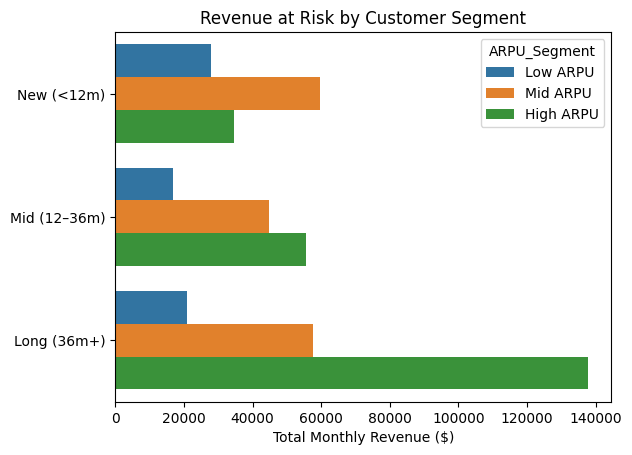

In [ ]:

sns.barplot(
    data=segment_summary,
    x="Total_Revenue",
    y="Tenure_Segment",
    hue="ARPU_Segment"
)

plt.title("Revenue at Risk by Customer Segment")
plt.xlabel("Total Monthly Revenue ($)")
plt.ylabel("")
plt.show()


## 6. Interpretable Churn Modeling

We use logistic regression to identify *drivers* of churn rather than
optimize prediction accuracy. Interpretability is prioritized over complexity.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Select features
features = [
    "tenure",
    "MonthlyCharges",
    "Contract",
    "PaymentMethod",
    "InternetService",
    "TechSupport",
    "OnlineSecurity",
    "PaperlessBilling"
]

X = df[features]
y = df["Churn_Flag"]

# One-hot encode categorical variables
X = pd.get_dummies(X, drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)


In [ ]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)


LogisticRegression(max_iter=1000)

## 7. Churn Drivers (Odds Ratios)

Odds ratios allow us to translate model coefficients into
business-understandable drivers of churn risk.


In [ ]:
coefficients = pd.DataFrame({
    "Feature": X_train.columns,
    "Coefficient": model.coef_[0]
})

coefficients["Odds_Ratio"] = np.exp(coefficients["Coefficient"])

coefficients.sort_values("Odds_Ratio", ascending=False).head(10)


,Feature,Coefficient,Odds_Ratio
1,MonthlyCharges,0.342090,1.407887
7,InternetService_Fiber optic,0.276683,1.318748
5,PaymentMethod_Electronic check,0.197732,1.218635
13,PaperlessBilling_Yes,0.186836,1.205429
6,PaymentMethod_Mailed check,0.047252,1.048386
4,PaymentMethod_Credit card (automatic),0.005343,1.005357
9,TechSupport_No internet service,-0.119394,0.887458
11,OnlineSecurity_No internet service,-0.119394,0.887458
8,InternetService_No,-0.119394,0.887458
10,TechSupport_Yes,-0.218358,0.803838


## 8. Quantifying Monthly Revenue at Risk

We estimate revenue leakage by combining churn probability
with segment-level revenue.


In [ ]:
roi_df = segment_summary.copy()

roi_df["Monthly_Revenue_at_Risk"] = (
    roi_df["Total_Revenue"] * roi_df["Churn_Rate"]
)

roi_df.sort_values("Monthly_Revenue_at_Risk", ascending=False)


,Tenure_Segment,ARPU_Segment,Customers,Churn_Rate,Avg_Monthly_Revenue,Total_Revenue,Monthly_Revenue_at_Risk
1,New (<12m),Mid ARPU,857,0.543757,69.572404,59623.55,32420.740140
2,New (<12m),High ARPU,375,0.738667,92.438400,34664.40,25605.436800
8,Long (36m+),High ARPU,1378,0.184325,99.908055,137673.30,25376.646009
5,Mid (12–36m),High ARPU,589,0.453311,94.511885,55667.50,25234.673175
4,Mid (12–36m),Mid ARPU,654,0.238532,68.596483,44862.10,10701.051376
0,New (<12m),Low ARPU,943,0.311771,29.571792,27886.20,8694.106893
7,Long (36m+),Mid ARPU,834,0.091127,68.944604,57499.80,5239.789928
3,Mid (12–36m),Low ARPU,613,0.083197,27.502529,16859.05,1402.628956
6,Long (36m+),Low ARPU,789,0.035488,26.521039,20925.10,742.589100


## 9. Target Segment Selection

From a consulting perspective, we focus intervention efforts
where revenue impact is highest.


In [ ]:
target_segment = roi_df[
    (roi_df["Tenure_Segment"] == "Mid (12–36m)") &
    (roi_df["ARPU_Segment"] == "High ARPU")
]

target_segment


,Tenure_Segment,ARPU_Segment,Customers,Churn_Rate,Avg_Monthly_Revenue,Total_Revenue,Monthly_Revenue_at_Risk
5,Mid (12–36m),High ARPU,589,0.453311,94.511885,55667.5,25234.673175


## 10. Retention Strategy ROI Analysis

We simulate three retention strategies and evaluate their ROI:
1. Tech support upsell
2. Payment method migration
3. Blanket discounts


In [ ]:
customers = int(target_segment["Customers"])
arpu = float(target_segment["Avg_Monthly_Revenue"])
churn_rate = float(target_segment["Churn_Rate"])

# Revenue per retained customer (6 months)
retained_revenue = arpu * 6


/tmp/ipython-input-1011596968.py:1: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  customers = int(target_segment["Customers"])
/tmp/ipython-input-1011596968.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  arpu = float(target_segment["Avg_Monthly_Revenue"])
/tmp/ipython-input-1011596968.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  churn_rate = float(target_segment["Churn_Rate"])


In [ ]:
interventions = pd.DataFrame({
    "Intervention": [
        "Tech Support Upsell",
        "Payment Method Migration",
        "Blanket Discount"
    ],
    "Churn_Reduction": [0.20, 0.10, 0.15],
    "Cost_per_Customer": [10*6, 5, 15*6]  # monthly costs scaled
})

interventions["Customers_Saved"] = (
    customers * churn_rate * interventions["Churn_Reduction"]
)

interventions["Revenue_Saved"] = (
    interventions["Customers_Saved"] * retained_revenue
)

interventions["Total_Cost"] = (
    customers * interventions["Cost_per_Customer"]
)

interventions["ROI"] = (
    interventions["Revenue_Saved"] / interventions["Total_Cost"]
)

interventions.sort_values("ROI", ascending=False)


,Intervention,Churn_Reduction,Cost_per_Customer,Customers_Saved,Revenue_Saved,Total_Cost,ROI
1,Payment Method Migration,0.10,5,26.70,15140.803905,2945,5.141190
0,Tech Support Upsell,0.20,60,53.40,30281.607810,35340,0.856865
2,Blanket Discount,0.15,90,40.05,22711.205857,53010,0.428432


## Executive Takeaway

This analysis demonstrates how analytics is used in real consulting work:
- Start with business framing
- Prioritize revenue impact
- Use interpretable models
- Optimize decisions, not metrics

Targeted service interventions deliver significantly higher ROI
than blanket discounts when evaluated through a revenue lens.
